In [1]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph import networks
import voxelmorph as vxm
from tqdm.notebook import trange


In [2]:
data = dict(np.load('mnist.npz'))

In [3]:
x_train_all = data['x_train'].astype('float')/255
x_test_all = data['x_test'].astype('float')/255

x_train_all = np.pad(x_train_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]
x_test_all = np.pad(x_test_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]

vol_shape = list(x_train_all.shape[1:-1])

In [4]:
# extract all 3s
digit = 3

x_train = x_train_all[data['y_train'] == digit, ...]
y_train = data['y_train'][data['y_train'] == digit]
x_test = x_test_all[data['y_test'] == digit, ...].astype('float')/255
y_test = data['y_test'][data['y_test'] == digit]

In [5]:
# from torchvision.io import read_image
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, img_labels,img_data, transform=None, target_transform=None):
        self.img_data = img_data.astype(np.float32)
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        label = self.img_labels[idx]
        image = self.img_data[idx].transpose(-1,0,1)
        if self.transform:
            image = self.transform(image[idx])
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
dataset = MNISTDataset(y_train, x_train,)

In [7]:
from torch.utils.data import DataLoader
device = torch.device('cuda:1')
train_dataloader = DataLoader(dataset,batch_size=8,shuffle=True)

In [8]:
train_features,_ = next(iter(train_dataloader))

In [9]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

In [10]:
altas = torch.mean(train_features,0)

In [11]:
model = torch.compile(networks.TemplateCreation((32,32),altas,nb_unet_features=[enc_nf, dec_nf])).to(device)

/home/junyi/.conda/envs/mainpyenv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
image_loss_func = nn.MSELoss()
neg_loss_func = lambda _, y_pred: image_loss_func(model.atlas, y_pred)
losses = [image_loss_func, neg_loss_func, nn.MSELoss(), vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

In [14]:
shape = (32,32)
zeros =torch.zeros((1,len(shape), *shape))

In [15]:
optimizer=torch.optim.Adam(model.parameters(), )


In [21]:
list(output[i].shape for i in range(4))

[torch.Size([8, 1, 32, 32]),
 torch.Size([8, 1, 32, 32]),
 torch.Size([8, 2, 32, 32]),
 torch.Size([8, 2, 32, 32])]

In [16]:
loss_his = []
step = 25
for _ in trange(100):
    loss_epoch = 0
    for batch, (train_features, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        train_features = train_features.to(device)
        output = model(train_features)
        output_p = [train_features,*[zeros.to(device) for _ in range(3)]]
        loss = 0
        for i in range(4):
            loss += losses[i](output[i],output_p[i])*loss_weights[i]
        loss.backward()
        # loss_m.backward()
        optimizer.step()
        loss_epoch+=loss.item()
    
        if (batch+1)%step == 0:
            break
    loss_his.append(loss_epoch)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/junyi/.conda/envs/mainpyenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 32, 32])) that is different to the input size (torch.Size([8, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/junyi/.conda/envs/mainpyenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 32, 32])) that is different to the input size (torch.Size([8, 2, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/junyi/.conda/envs/mainpyenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 32, 32])) that is different to the input size (torch.Size([8, 1, 32, 32])). This will li

KeyboardInterrupt: 

In [17]:
model.mean_stream.mean

tensor([[[-2.2405e-04, -1.5840e-04, -9.2753e-05,  ..., -1.9758e-04,
          -2.0403e-05,  1.5677e-04],
         [-3.7023e-05, -3.9047e-05, -4.1070e-05,  ..., -5.8655e-05,
           4.1641e-05,  1.4194e-04],
         [ 1.5000e-04,  8.0308e-05,  1.0613e-05,  ...,  8.0268e-05,
           1.0369e-04,  1.2710e-04],
         ...,
         [ 1.3373e-04,  6.7652e-05,  1.5700e-06,  ...,  6.7681e-05,
           8.7584e-05,  1.0749e-04],
         [ 3.1149e-04,  3.0004e-04,  2.8859e-04,  ...,  3.5841e-04,
           3.2498e-04,  2.9155e-04],
         [ 4.8926e-04,  5.3243e-04,  5.7561e-04,  ...,  6.4914e-04,
           5.6238e-04,  4.7562e-04]],

        [[ 1.2441e-03,  1.4736e-03,  1.7031e-03,  ...,  1.5792e-03,
           1.8905e-03,  2.2018e-03],
         [ 1.5156e-03,  1.6965e-03,  1.8774e-03,  ...,  1.6721e-03,
           1.9822e-03,  2.2922e-03],
         [ 1.7870e-03,  1.9194e-03,  2.0517e-03,  ...,  1.7649e-03,
           2.0738e-03,  2.3826e-03],
         ...,
         [ 1.8287e-03,  1

In [18]:
atlas = model.atlas.cpu().detach()

In [18]:
loss.item()

5.781912477687001e-07

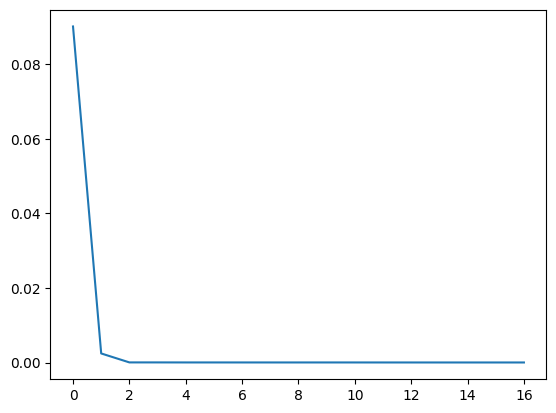

In [19]:
plt.plot(np.array(loss_his)/(batch+1))

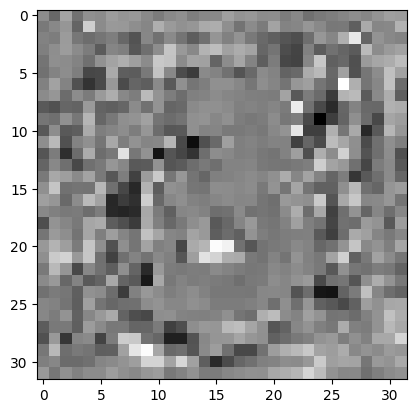

In [20]:
plt.imshow(atlas[0],cmap='gray')